# Deep CTR (Attention and Self-attention)

In [1]:
import numpy as np
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from deepctr_torch.models import DeepFM
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    roc_auc_score,
    log_loss,
)


DeepCTR-PyTorch version 0.2.1 detected. Your version is 0.2.0.
Use `pip install -U deepctr-torch` to upgrade.Changelog: https://github.com/shenweichen/DeepCTR-Torch/releases/tag/v0.2.1


In [2]:
# pass in column names for each CSV
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('C:\\Users\\Lina\\ml-100k\\ml-100k\\u.user', sep='|', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('C:\\Users\\Lina\\ml-100k\\ml-100k\\u.data', sep='\t', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first five columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date', 'imdb_url']
movies = pd.read_csv('C:\\Users\\Lina\\ml-100k\\ml-100k\\u.item', sep='|', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 
                                                  'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                                                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                                                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
                     dtype={'release_date': "S100", 'imdb_url': "S200"},encoding='ansi')

# create one merged DataFrame
movie_ratings = pd.merge(movies[['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL']], ratings)
data = pd.merge(movie_ratings, users)
data.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,60,M,retired,95076


In [3]:
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
import torch
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr_torch.inputs import SparseFeat, get_feature_names
from deepctr_torch.models import DeepFM

#if __name__ == "__main__":

#data = pd.read_csv('C:\\Users\\Lina\\DeepCTR-Torch\\examples\\movielens_sample.txt', sep=',')
sparse_features = ["movie_id", "user_id",
                       "sex", "age", "occupation", "zip_code"]
target = ['rating']

    # 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
    # 2.count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique())
                              for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

    # 3.generate input data for model
train, test = train_test_split(data, test_size=0.25)
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}
    # 4.Define Model,train,predict and evaluate

device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)
model.compile("adam", "mse", metrics=['mse'], )
history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=50, verbose=2, validation_split=0.2)

pred_ans = model.predict(test_model_input, batch_size=256)
rmse=math.sqrt(round(mean_squared_error(test[target].values, pred_ans), 4))
print("test RMSE",rmse )



cpu
Train on 60000 samples, validate on 15000 samples, 235 steps per epoch
Epoch 1/50
8s - loss:  2.2580 - mse:  2.2549 - val_mse:  0.9446
Epoch 2/50
9s - loss:  0.8846 - mse:  0.8845 - val_mse:  0.9253
Epoch 3/50
8s - loss:  0.8648 - mse:  0.8646 - val_mse:  0.9181
Epoch 4/50
8s - loss:  0.8568 - mse:  0.8571 - val_mse:  0.9186
Epoch 5/50
9s - loss:  0.8541 - mse:  0.8540 - val_mse:  0.9170
Epoch 6/50
8s - loss:  0.8509 - mse:  0.8512 - val_mse:  0.9177
Epoch 7/50
8s - loss:  0.8500 - mse:  0.8502 - val_mse:  0.9179
Epoch 8/50
9s - loss:  0.8485 - mse:  0.8487 - val_mse:  0.9278
Epoch 9/50
9s - loss:  0.8467 - mse:  0.8471 - val_mse:  0.9182
Epoch 10/50
9s - loss:  0.8458 - mse:  0.8462 - val_mse:  0.9272
Epoch 11/50
8s - loss:  0.8447 - mse:  0.8449 - val_mse:  0.9170
Epoch 12/50
8s - loss:  0.8447 - mse:  0.8449 - val_mse:  0.9165
Epoch 13/50
8s - loss:  0.8427 - mse:  0.8427 - val_mse:  0.9155
Epoch 14/50
8s - loss:  0.8409 - mse:  0.8412 - val_mse:  0.9156
Epoch 15/50
9s - loss:  

In [5]:
test_model_input

{'movie_id': 17107     777
 43437     172
 64909     275
 54840    1400
 84976      99
 57933      32
 70899      71
 34371     264
 58930     762
 4395      217
 21898     303
 30026      93
 19504      96
 76531     293
 66344     229
 18358     361
 91825    1083
 70421     602
 39677     136
 52500     366
 60342     217
 33407     731
 22261     321
 2042      183
 60592     430
 68971     552
 21261     142
 99087     267
 768      1167
 98182     332
          ... 
 46019       6
 6142      249
 68036     186
 55075     197
 13324     442
 17267      86
 39281      64
 1159      563
 59280     513
 31026     221
 63015      37
 14183     120
 72748     317
 79399     236
 46489     409
 46245    1227
 66680     841
 61133     427
 42631     927
 29585     628
 52877     617
 12613     209
 69815     565
 40860     172
 17938     508
 60105       6
 65467     723
 58613     621
 94196     483
 77615     928
 Name: movie_id, Length: 25000, dtype: int64, 'user_id': 17107    513
 43

In [7]:
np.sqrt(mean_squared_error(test[target].values, pred_ans))

0.9443003606740912

In [8]:
mean_absolute_error(test[target].values, pred_ans)

0.7339326433378458

In [9]:
r2_score(test[target].values, pred_ans)

0.29029836526678054

In [10]:
explained_variance_score(test[target].values, pred_ans)

0.2989976908974725

___________________________________________________________________________

# Autoencoders

In [25]:
## -*- coding: utf-8 -*-

#ratings-u.data df
#movies-u.item movie_df

In [10]:
data.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,0,Toy Story (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,307,4,887736532,50,1,15,716
1,3,Get Shorty (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,307,5,887737890,50,1,15,716
2,4,Copycat (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),307,4,887739608,50,1,15,716
3,6,Twelve Monkeys (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,307,4,887738847,50,1,15,716
4,7,Babe (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),307,5,887736696,50,1,15,716


In [11]:
# capture all genre columns, get them to one column, remove them after it is done
genres = ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
          'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
          'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies['genre'] = movies[genres].idxmax(1)
movies = movies.drop(genres, axis=1)
movies.head(5)

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,genre
0,1,Toy Story (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation
1,2,GoldenEye (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,Action
2,3,Four Rooms (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,Thriller
3,4,Get Shorty (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,Action
4,5,Copycat (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),Crime


In [12]:
movies = movies[['movie_id', 'movie_title', 'release_date', 'IMDb_URL', 'genre']]

In [13]:
movies.head(5)

,movie_id,movie_title,release_date,IMDb_URL,genre
0,1,Toy Story (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation
1,2,GoldenEye (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?GoldenEye%20(...,Action
2,3,Four Rooms (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Four%20Rooms%...,Thriller
3,4,Get Shorty (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Get%20Shorty%...,Action
4,5,Copycat (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Copycat%20(1995),Crime


In [14]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_df = data.pivot(index   = 'user_id', 
                                 columns = 'movie_id', 
                                 values  = 'rating').fillna(0)
users_items_matrix_df.head(10)

movie_id,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
users_items_matrix_df.shape

(943, 1682)

In [16]:
users_items_matrix_df.values.mean()*100

22.254600202001605

In [17]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

Using TensorFlow backend.


In [18]:
# input
X = users_items_matrix_df.values
y = users_items_matrix_df.values

In [19]:
# Build model
model = autoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss='mse')
    
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       (None, 1682)              0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               861696    
_________________________________________________________________
LatentSpace (Dense)          (None, 256)               131328    
_________________________________________________________________
Dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               131584    
_________________________________________________________________
UserScorePred (Dense)        (None, 1682)              862866    
Total params: 1,987,474
Trainable params: 1,987,474
Non-trainable params: 0
_________________________________________________________________


In [20]:
hist = model.fit(x=X, y=y,
                  epochs=50,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.25)

Train on 707 samples, validate on 236 samples
Epoch 1/50
707/707 [==============================] - ETA: 8s - loss: 2.297 - ETA: 4s - loss: 2.355 - ETA: 2s - loss: 2.319 - ETA: 2s - loss: 2.338 - ETA: 1s - loss: 2.306 - ETA: 1s - loss: 2.310 - ETA: 0s - loss: 2.289 - ETA: 0s - loss: 2.244 - ETA: 0s - loss: 2.248 - ETA: 0s - loss: 2.242 - ETA: 0s - loss: 2.213 - 2s 3ms/step - loss: 2.2095 - val_loss: 1.0758
Epoch 2/50
707/707 [==============================] - ETA: 0s - loss: 2.027 - ETA: 0s - loss: 1.937 - ETA: 0s - loss: 1.950 - ETA: 0s - loss: 1.933 - ETA: 0s - loss: 1.931 - ETA: 0s - loss: 1.952 - ETA: 0s - loss: 1.943 - ETA: 0s - loss: 1.936 - ETA: 0s - loss: 1.948 - ETA: 0s - loss: 1.937 - ETA: 0s - loss: 1.917 - 1s 1ms/step - loss: 1.9194 - val_loss: 1.0338
Epoch 3/50
707/707 [==============================] - ETA: 0s - loss: 1.958 - ETA: 0s - loss: 1.874 - ETA: 0s - loss: 1.820 - ETA: 0s - loss: 1.812 - ETA: 0s - loss: 1.796 - ETA: 0s - loss: 1.764 - ETA: 0s - loss: 1.746 - ETA:

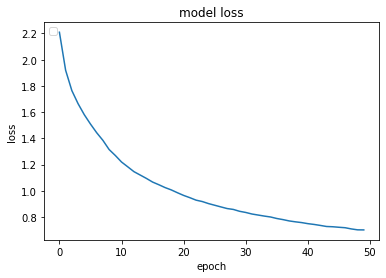

In [21]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

plot_hist(hist)

In [22]:
# Predict new Matrix Interactions, set score zero on visualized movies
new_matrix = model.predict(X) * (X == 0)

In [23]:
new_matrix

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.1219227e-01,  3.0616261e-02,  3.3057276e-02],
       [ 0.0000000e+00,  2.2806293e-01, -2.6848307e-02, ...,
        -2.7985957e-02,  2.2622450e-01,  8.7661790e-03],
       [ 1.3832800e+00, -2.2412971e-01, -1.6179145e-03, ...,
        -1.3893093e-01,  5.6018010e-02,  1.9036528e-02],
       ...,
       [ 0.0000000e+00, -3.7896293e-01,  1.6465496e-01, ...,
        -1.9980571e-01, -1.9602355e-01,  2.5862407e-02],
       [ 1.7530798e+00, -6.8435490e-02,  1.1157218e-01, ...,
         9.4607444e-03,  2.0699619e-01, -2.4190597e-01],
       [ 3.0225501e+00,  0.0000000e+00,  9.3436718e-01, ...,
         1.4107564e-01, -1.3419594e-01, -1.1969335e-01]], dtype=float32)

In [24]:
mean_absolute_error(X, new_matrix)

0.4500963027975641

In [25]:
r2_score(X, new_matrix)

-1.3092778178265017

In [26]:
explained_variance_score(X, new_matrix)

-1.1789626930195822

In [28]:
np.sqrt(mean_squared_error(X, new_matrix))

1.0072599274183947

In [29]:
# converting the reconstructed matrix back to a Pandas dataframe
new_users_items_matrix_df  = pd.DataFrame(new_matrix, 
                                          columns = users_items_matrix_df.columns, 
                                          index   = users_items_matrix_df.index)
new_users_items_matrix_df.head()

movie_id,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.030112,-0.152597,0.001085,-0.076188,-0.042833,-0.077758,0.039018,0.112192,0.030616,0.033057
1,0.000000,0.228063,-0.026848,-0.009833,0.023907,0.141491,1.430039,0.591600,1.184669,0.000000,...,0.138888,-0.054730,-0.012993,-0.041068,0.162508,-0.049401,-0.098232,-0.027986,0.226224,0.008766
2,1.383280,-0.224130,-0.001618,-0.078997,0.021186,0.035033,0.897842,0.311030,1.033786,0.349267,...,-0.313869,-0.250760,0.037642,0.040282,-0.022473,-0.030705,-0.223501,-0.138931,0.056018,0.019037
3,1.295857,0.018007,0.443385,0.427138,0.079118,-0.023624,1.009432,0.274100,0.445820,-0.142240,...,-0.266426,-0.012185,-0.028761,0.127904,0.154744,-0.156343,-0.164731,-0.145512,0.088300,0.155381
4,0.000000,0.000000,0.092827,1.256835,0.340877,-0.306521,1.702425,1.216657,0.962747,0.237698,...,-0.203635,-0.154895,0.061631,0.025686,-0.053250,-0.028420,-0.073569,0.290137,0.132103,0.011679


In [30]:
print(new_users_items_matrix_df.values.min(), new_users_items_matrix_df.values.max())

-1.2648584 5.0035877


In [31]:
def recommender_for_user(user_id, interact_matrix, df_content, topn = 10):
    pred_scores = interact_matrix.loc[user_id].values

    df_scores   = pd.DataFrame({'movie_id': list(users_items_matrix_df.columns), 
                               'score': pred_scores})

    df_rec      = df_scores.set_index('movie_id')\
                    .join(df_content.set_index('movie_id'))\
                    .sort_values('score', ascending=False)\
                    .head(topn)[['score', 'movie_title']]
    
    return df_rec[df_rec.score > 0]

In [32]:
recommender_for_user(
    user_id         = 5, 
    interact_matrix = users_items_matrix_df, 
    df_content      = movies)

,score,movie_title
movie_id,,
473,5.0,James and the Giant Peach (1996)
492,5.0,East of Eden (1955)
489,5.0,Notorious (1946)
488,5.0,Sunset Blvd. (1950)
487,5.0,Roman Holiday (1953)
486,5.0,Sabrina (1954)
484,5.0,"Maltese Falcon, The (1941)"
483,5.0,Casablanca (1942)
482,5.0,Some Like It Hot (1959)


In [33]:
recommender_for_user(
    user_id         = 5, 
    interact_matrix = new_users_items_matrix_df, 
    df_content      = movies)

,score,movie_title
movie_id,,
171,3.231872,Delicatessen (1991)
180,3.141510,Apocalypse Now (1979)
602,3.036081,"American in Paris, An (1951)"
653,2.741564,Touch of Evil (1958)
654,2.727176,Chinatown (1974)
209,2.720826,This Is Spinal Tap (1984)
195,2.600734,"Terminator, The (1984)"
233,2.519007,Under Siege (1992)
96,2.452820,Terminator 2: Judgment Day (1991)
